1. Ознакомьтесь с датасетом образцов эмоциональной речи

    **Toronto emotional speech set (TESS)**:

    https://dataverse.scholarsportal.info/dataset.xhtml?persistentId=doi:10.5683/SP2/E8H2MF

    Ссылка для загрузки данных: https://storage.googleapis.com/datasets_ai/Base/12_audio/dataverse_files.zip

2. Разберите датасет;
3. Подготовьте и разделите данные на обучающие и тестовые;
4. Разработайте классификатор, показывающий на тесте точность распознавания эмоции не менее 98%;
5. Ознакомьтесь с другим датасетом похожего содержания

    **Surrey Audio-Visual Expressed Emotion (SAVEE)**:

    https://www.kaggle.com/ejlok1/surrey-audiovisual-expressed-emotion-savee

    Ссылка для загрузки данных: https://storage.googleapis.com/datasets_ai/Base/12_audio/archive.zip

6. Прогоните обученный классификатор на файлах из датасета **SAVEE** по вашему выбору;
7. Сделайте выводы.

In [ ]:
import numpy as np              # Массивы
import matplotlib.pyplot as plt # Отрисовка графиков
import IPython.display as ipd   # Проигрывание аудио в colab

from google.colab import drive  # Связь с google диском
import gdown                    # Загрузка из google облака
import os                       # Работа с папками и файлами
from tqdm import tqdm
import re

# Преобразование категориальных данных в one hot encoding
from tensorflow.keras.utils import to_categorical

import time                     # Утилиты работы со временем
import random                   # Работа со случайными числами
import math                     # Математические функции

# Сохранение и загрузка структур данных Python
import pickle
import librosa                  # Параметризация аудио

# Оптимизаторы для обучения моделей
from tensorflow.keras.optimizers import Adam, RMSprop

# Конструирование и загрузка моделей нейронных сетей
from tensorflow.keras.models import Sequential, Model, load_model

# Основные слои
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM

# Разбиение на обучающую и проверочную выборку
from sklearn.model_selection import train_test_split

# Кодирование категориальных меток, нормирование числовых данных
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings             # Отключение предупреждений
warnings.filterwarnings('ignore')

%matplotlib inline 

In [ ]:
# Загрузка датасета из облака
gdown.download('https://storage.googleapis.com/datasets_ai/Base/12_audio/dataverse_files.zip')

Downloading...
From: https://storage.googleapis.com/datasets_ai/Base/12_audio/dataverse_files.zip
To: /content/dataverse_files.zip
100%|██████████| 224M/224M [00:02<00:00, 98.3MB/s]


'dataverse_files.zip'

In [ ]:
# create the folder to unpack the archive
!mkdir data/
# Распаковка архива на локальный диск colab
!unzip -qo dataverse_files.zip -d data    
!rm data/MANIFEST.TXT /  # check unzipped
!ls data                 # check unzipped

mkdir: cannot create directory ‘data/’: File exists
rm: cannot remove '/': Is a directory
OAF_back_angry.wav	OAF_reach_happy.wav	 YAF_jail_sad.wav
OAF_back_disgust.wav	OAF_reach_neutral.wav	 YAF_jar_angry.wav
OAF_back_fear.wav	OAF_reach_ps.wav	 YAF_jar_disgust.wav
OAF_back_happy.wav	OAF_reach_sad.wav	 YAF_jar_fear.wav
OAF_back_neutral.wav	OAF_read_angry.wav	 YAF_jar_happy.wav
OAF_back_ps.wav		OAF_read_disgust.wav	 YAF_jar_neutral.wav
OAF_back_sad.wav	OAF_read_fear.wav	 YAF_jar_ps.wav
OAF_bar_angry.wav	OAF_read_happy.wav	 YAF_jar_sad.wav
OAF_bar_disgust.wav	OAF_read_neutral.wav	 YAF_join_angry.wav
OAF_bar_fear.wav	OAF_read_ps.wav		 YAF_join_disgust.wav
OAF_bar_happy.wav	OAF_read_sad.wav	 YAF_join_fear.wav
OAF_bar_neutral.wav	OAF_red_angry.wav	 YAF_join_happy.wav
OAF_bar_ps.wav		OAF_red_disgust.wav	 YAF_join_neutral.wav
OAF_bar_sad.wav		OAF_red_fear.wav	 YAF_join_ps.wav
OAF_base_angry.wav	OAF_red_happy.wav	 YAF_join_sad.wav
OAF_base_disgust.wav	OAF_red_neutral.wav	 YAF_judge_angry.wav
OA

In [ ]:
ipd.display(ipd.Audio('data/OAF_cheek_angry.wav'))

## Data preparation

In [ ]:
## Get label names from files
directory_name = 'data/'
files_names = os.listdir(directory_name) # get files names from the folder

class_dict = {}
for name in files_names:
  name = os.path.splitext(name)[0] #get rif of extension 
  emotion = name.split('_')[-1] 

  if emotion in class_dict:
        class_dict[emotion] +=1
  else:
        class_dict[emotion] = 0                   

class_list = sorted(list(class_dict.keys()))

In [ ]:
#class_dict

In [ ]:
class_list

['angry', 'disgust', 'fear', 'happy', 'neutral', 'ps', 'sad']

In [ ]:
# Установка констант

FILE_DIR = 'data/'                     # Папка с файлами датасета
CLASS_COUNT = len(class_list)             # Количество классов
CLASS_FILES = 100                         # Общее количество файлов в каждом классе
TEST_SPLIT = 0.5                          # Доля тестовой выборки в провереочной + тестовой
VALIDATION_SPLIT = 0.2                    # Доля проверочной и тестовой выборки в основном наборе
DURATION_SEC = 15                         # Анализируемая длительность аудиосигнала
N_FFT = 8192                              # Размер окна преобразования Фурье для расчета спектра
HOP_LENGTH = 512                          # Объем данных для расчета одного набора признаков

In [ ]:
# Функция параметризации аудио

def get_features(y,                     # волновое представление сигнала
                 sr,                    # частота дискретизации сигнала y
                 n_fft=N_FFT,           # размер скользящего окна БПФ
                 hop_length=HOP_LENGTH  # шаг скользящего окна БПФ
                 ):
    # Вычисление различных параметров (признаков) аудио

    # Хромаграмма
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Мел-кепстральные коэффициенты
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Среднеквадратическая амплитуда
    rmse = librosa.feature.rms(y=y, hop_length=hop_length)
    # Спектральный центроид
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Ширина полосы частот
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Спектральный спад частоты
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Пересечения нуля
    zcr = librosa.feature.zero_crossing_rate(y, hop_length=hop_length)
    
    # Сборка признаков в общий список:
    # На один файл несколько векторов признаков, количество определяется
    # продолжительностью аудио и параметром hop_length в функциях расчета признаков
    features = {'rmse': rmse, 
                'spct': spec_cent, 
                'spbw': spec_bw,
                'roff': rolloff,
                'zcr' : zcr,
                'mfcc': mfcc,
                'stft': chroma_stft}

    return features

In [ ]:
# Функция объединения признаков в набор векторов
def stack_features(feat  # словарь признаков, отдельные векторы по ключу каждого признака
                   ):
    features = None
    for v in feat.values():
        features = np.vstack((features, v)) if features is not None else v

    return features.T

Parametrization of one data sample (check)

In [ ]:
# Проверка параметризации одного произведения
y, sr = librosa.load(f'data/OAF_cheek_angry.wav', mono=True, duration=DURATION_SEC)
features = get_features(y, sr)

In [ ]:
print({k: v.shape for k, v in features.items()})

{'rmse': (1, 73), 'spct': (1, 73), 'spbw': (1, 73), 'roff': (1, 73), 'zcr': (1, 73), 'mfcc': (20, 73), 'stft': (12, 73)}


In [ ]:
# Проверка формирования набора признаков
feature_set = stack_features(features)
feature_set.shape

(73, 37)

In [ ]:
# Функция формирования набора признаков и метки класса для аудиофайла
def get_feature_list_from_file(song_name,     # имя аудиофайла
                               duration_sec,  # длительность аудио в секундах
                               directory = FILE_DIR
                               ):
  
    file_path = directory + song_name
    # Загрузка в y первых duration_sec секунд аудиосигнала
    y, sr = librosa.load(file_path, mono=True, duration=duration_sec)

    # Извлечение параметров из аудиосигнала
    features = get_features(y, sr)
    feature_set = stack_features(features)

    # Определение класса объекта
    emotion = os.path.splitext(song_name)[0] #get rif of extension 
    emotion = emotion.split('_')[-1]
    class_index = class_list.index(emotion)

    # Перевод номера класса в one hot encoding
    y_label = to_categorical(class_index, CLASS_COUNT)

    return feature_set, y_label

In [ ]:
def process_file(filename,
                 duration_sec=DURATION_SEC, # длительность аудио в секундах
                 directory=FILE_DIR,
                 ):
    x_list = []
    y_list = []

    feature_set, y_label = get_feature_list_from_file(filename,
                                                      duration_sec,
                                                      directory)
    # Добавление данных в наборы
    for j in range(feature_set.shape[0]):
        x_list.append(feature_set[j])
        y_list.append(y_label)

    return np.array(x_list).astype('float32'), \
           np.array(y_list).astype('float32')

In [ ]:
# Функция формирования набора данных из файлов всех классов по диапазону номеров файлов

def extract_data(duration_sec=DURATION_SEC,  # длительность аудио в секундах
                 directory = FILE_DIR
                 ):

    # Списки для последовательностей входных данных и меток класса
    x_data = None
    y_data = None

    # Фиксация времени старта формирования выборки
    curr_time = time.time()

    # Для всех классов:
    for filename in tqdm(files_names):
        # Обработка одного файла и добавление данных к общим массивам
        file_x_data, file_y_data = process_file(filename, duration_sec, directory)

        x_data = file_x_data if x_data is None else np.vstack([x_data, file_x_data])
        y_data = file_y_data if y_data is None else np.vstack([y_data, file_y_data])

    # Возврат массивов набора данных
    return x_data, y_data

In [ ]:
# Формирование тренировочного (основного) набора данных
x_train_data, y_train_data = extract_data()

100%|██████████| 2800/2800 [11:51<00:00,  3.94it/s]


In [ ]:
# Сохранение/восстановление датасета аудио
with open('/content/audio_data.pickle', 'wb') as f:
    pickle.dump((x_train_data, y_train_data), f)

In [ ]:
with open('/content/audio_data.pickle', 'rb') as f:
    x_train_data, y_train_data = pickle.load(f)

In [ ]:
# Вывод формы данных обучающего набора
print(x_train_data.shape, x_train_data.dtype)
print(y_train_data.shape, y_train_data.dtype)

## Data normalization

In [ ]:
# Нормирование признаков в соответствии со стандартным нормальным распределением
x_scaler = StandardScaler()
x_train_data_scaled = x_scaler.fit_transform(x_train_data)

In [ ]:
# Разделение набора данных на обучающую и проверочную выборки
# Параметр stratify указывает метки классов, по которым происходит балансировка разделения
x_train, x_val, y_train, y_val = train_test_split(x_train_data_scaled,
                                                  y_train_data,
                                                  stratify=y_train_data,
                                                  test_size=VALIDATION_SPLIT)

In [ ]:
x_test, x_val, y_test, y_val = train_test_split(x_val,
                                                y_val,
                                                stratify=y_val,
                                                test_size=TEST_SPLIT)

In [ ]:
# Проверка формы и типа данных обучающей и проверочной выборок
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print()
print(x_val.shape, x_val.dtype)
print(y_val.shape, y_val.dtype)

(199400, 37) float32
(199400, 7) float32

(24926, 37) float32
(24926, 7) float32


# Models

In [ ]:
# Функция сборки и обучения классификатора на полносвязных слоях

def create_train_classifier(in_shape,       # форма входных данных модели
                            epochs=50,      # количество эпох обучения
                            batch_size=512  # размер батча
                            ):
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=in_shape))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(CLASS_COUNT, activation='softmax'))

    # Компиляция модели
    model.compile(optimizer=Adam(lr=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    model.summary()

    # Обучение модели
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val))

    # Вывод графика точности распознавания на обучающей и проверочной выборках
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['accuracy'], label='Точность на обучающем наборе')
    plt.plot(history.history['val_accuracy'], label='Точность на проверочном наборе')
    plt.xticks(range(epochs))
    plt.xlabel('Эпоха')
    plt.ylabel('Точность')
    plt.legend()
    plt.show()

    return model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 256)               9728      
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization_6 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_35 (Dense)            (None, 128)               32896     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_7 (Batc  (None, 128)              512       
 hNormalization)                                      

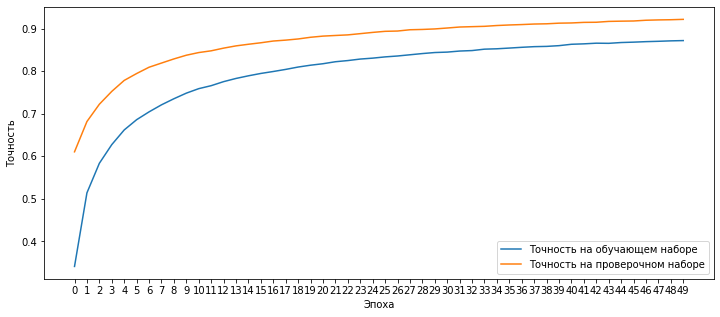

In [ ]:
model_1 = create_train_classifier(x_train.shape[1:])

In [ ]:
# Сохранение/восстановление модели и выборок
# model.save('/content/model_audio.h5')
# with open('/content/audio_train_val.pickle', 'wb') as f:
#     pickle.dump((x_train, y_train, x_val, y_val, x_scaler), f)

# model = load_model('/content/model_audio.h5')
# with open('/content/audio_train_val.pickle', 'rb') as f:
#     x_train, y_train, x_val, y_val, x_scaler = pickle.load(f)

## Check accuracy

In [ ]:
# Функция оценки точности модели на заданной выборке

def eval_model(model,  # обученная модель нейронной сети
               x,      # входные данные
               y_true  # выходные данные (верные ответы)
               ):
    loss, acc = model.evaluate(x, y_true)
    print(f'Ошибка: {loss}, точность: {acc}')

    # Построение матрицы ошибок
    y_pred = model.predict(x)
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title('Матрица ошибок нормализованная')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_list)
    disp.plot(ax=ax)
    plt.show() 

779/779 [==============================] - 2s 2ms/step - loss: 0.2269 - accuracy: 0.9223
Ошибка: 0.22693592309951782, точность: 0.9222899675369263


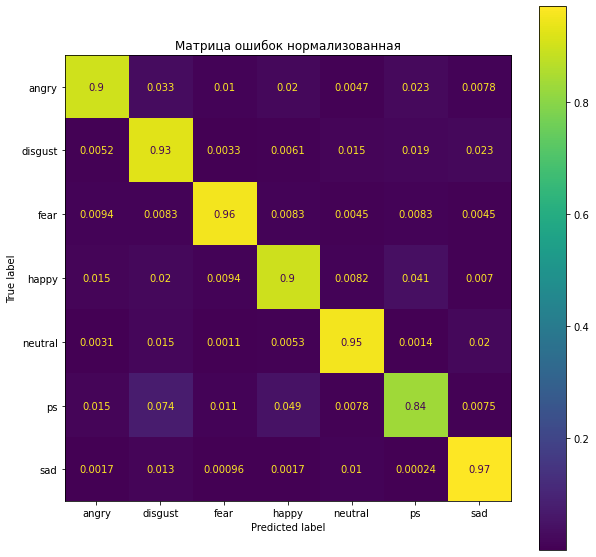

In [ ]:
# Оценка точности сети на проверочной выборке
eval_model(model_1, x_val, y_val)

779/779 [==============================] - 1s 2ms/step - loss: 0.2285 - accuracy: 0.9207
Ошибка: 0.22849346697330475, точность: 0.9206820726394653


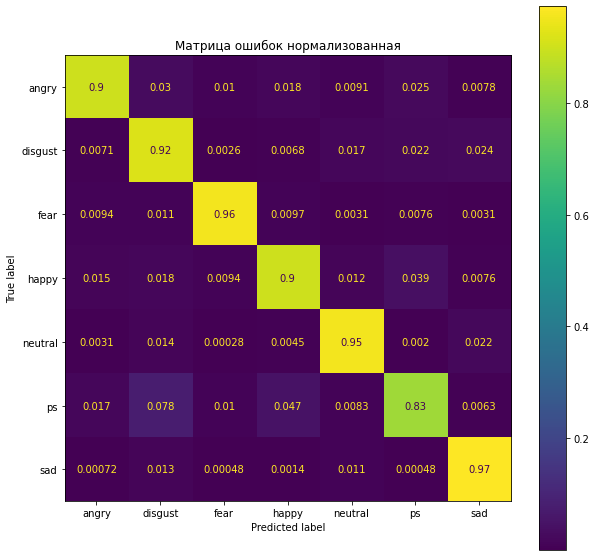

In [ ]:
# Оценка точности сети на тестовой выборке
eval_model(model_1, x_test, y_test)

## Data augmentation

In [ ]:
# Все операции в данном блоке выполняются поэлементно; в результате получаются массивы той же формы

# Квадрат значений
x_train_data_sqr = x_train_data ** 2

# Квадратный корень из модулей значений
x_train_data_sqrt = np.abs(x_train_data) ** 0.5

# Обратная величина
x_train_data_inv = 1. / x_train_data

# 2 в степени каждого значения
x_train_data_exp = 2. ** x_train_data

# Формирование нового тренировочного набора данных
x_train_data_aug = np.hstack([x_train_data, x_train_data_sqr, x_train_data_sqrt, x_train_data_exp])

# Проверка формы данных нового набора
print(x_train_data_aug.shape)

(249251, 148)


In [ ]:
# Нормирование признаков в соответствии со стандартным нормальным распределением
# Замена всех бесконечных значений на 0, иначе нормирование невозможно
x_train_data_aug[np.abs(x_train_data_aug) == math.inf] = 0

x_scaler_aug = StandardScaler()
x_train_data_aug_scaled = x_scaler_aug.fit_transform(x_train_data_aug)

In [ ]:
# Разделение набора данных на обучающую и проверочную выборки
x_train_aug, x_val_aug, y_train_aug, y_val_aug = train_test_split(x_train_data_aug_scaled,
                                                                  y_train_data,
                                                                  test_size=VALIDATION_SPLIT)


x_test_aug, x_val_aug, y_test_aug, y_val_aug = train_test_split(x_val_aug,
                                                                y_val_aug,
                                                                stratify=y_val_aug,
                                                                test_size=TEST_SPLIT)

In [ ]:
# Проверка формы и типа данных обучающей и проверочной выборок
print(x_train_aug.shape, x_train_aug.dtype)
print(y_train_aug.shape, y_train_aug.dtype)
print()
print(x_val_aug.shape, x_val_aug.dtype)
print(y_val_aug.shape, y_val_aug.dtype)

(199400, 148) float32
(199400, 7) float32

(24926, 148) float32
(24926, 7) float32


In [ ]:
# Функция компиляции и обучения модели с одними и теми же параметрами

def compile_train(model,           # модель нейронной сети
                  epochs=150,      # количество эпох обучения
                  batch_size=4096  # размер батча
                  ):
    # Компиляция
    model.compile(optimizer=Adam(lr=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    # Обучение
    history = model.fit(x_train_aug,
                        y_train_aug,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val_aug, y_val_aug))

    # Вывод графика обучения
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.show()

Epoch 1/150
49/49 [==============================] - 6s 102ms/step - loss: 1.8023 - accuracy: 0.3193 - val_loss: 1.6683 - val_accuracy: 0.4089
Epoch 2/150
49/49 [==============================] - 5s 104ms/step - loss: 1.5722 - accuracy: 0.4477 - val_loss: 1.4715 - val_accuracy: 0.4874
Epoch 3/150
49/49 [==============================] - 5s 103ms/step - loss: 1.3987 - accuracy: 0.5089 - val_loss: 1.3176 - val_accuracy: 0.5352
Epoch 4/150
49/49 [==============================] - 5s 100ms/step - loss: 1.2627 - accuracy: 0.5538 - val_loss: 1.1964 - val_accuracy: 0.5817
Epoch 5/150
49/49 [==============================] - 5s 99ms/step - loss: 1.1528 - accuracy: 0.5950 - val_loss: 1.0970 - val_accuracy: 0.6215
Epoch 6/150
49/49 [==============================] - 5s 100ms/step - loss: 1.0611 - accuracy: 0.6312 - val_loss: 1.0139 - val_accuracy: 0.6545
Epoch 7/150
49/49 [==============================] - 5s 101ms/step - loss: 0.9836 - accuracy: 0.6610 - val_loss: 0.9435 - val_accuracy: 0.6807


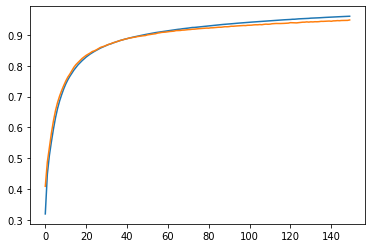

In [ ]:
input1 = Input(x_train_aug.shape[1:])

x1 = Dense(64, activation="elu")(input1)
x1 = Dense(64, activation="elu")(x1)

x2 = Dense(64, activation="elu")(input1)
x2 = Dense(40, activation="softmax")(x2)

x3 = Dense(64, activation="elu")(input1)
x3 = Dense(200, activation="softmax")(x3)

x4 = Dense(40, activation="softmax")(input1)

x5 = Dense(200, activation="softmax")(input1)

x6 = Dense(10, activation="softmax")(input1)

x7 = Dense(64, activation="elu")(input1)
x7 = Dense(10, activation="softmax")(x7)

x = concatenate([x1, x2, x3, x4, x5, x6, x7])

x = Dense(64, activation='elu')(x)
x = Dense(7, activation='softmax')(x)

model_2 = Model(input1, x)

compile_train(model_2)

779/779 [==============================] - 2s 2ms/step - loss: 0.2104 - accuracy: 0.9306
Ошибка: 0.21035714447498322, точность: 0.9305516481399536


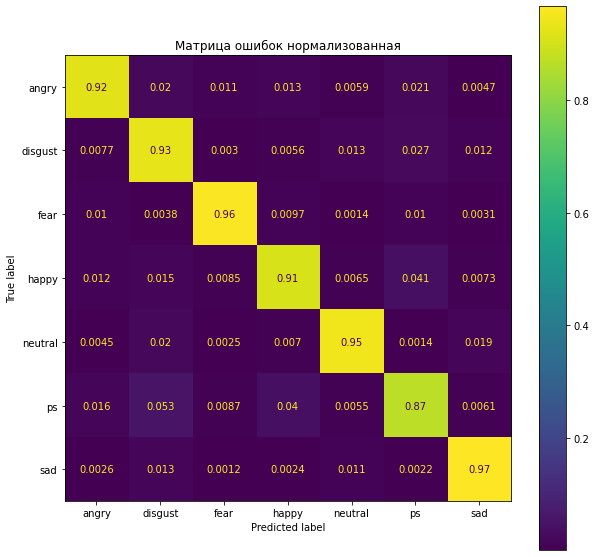

In [ ]:
# Оценка точности сети на тестовой выборке
eval_model(model_2, x_test_aug, y_test_aug)

## Other dataset

In [ ]:
# Загрузка датасета из облака
gdown.download('https://storage.googleapis.com/datasets_ai/Base/12_audio/archive.zip')


Downloading...
From: https://storage.googleapis.com/datasets_ai/Base/12_audio/archive.zip
To: /content/archive.zip
100%|██████████| 113M/113M [00:01<00:00, 66.1MB/s] 


'archive.zip'

In [ ]:
# create the folder to unpack the archive
!mkdir data_2/
# Распаковка архива на локальный диск colab
!unzip -qo dataverse_files.zip -d data_2    
!rm data_2/MANIFEST.TXT /  # check unzipped
!ls data_2                 # check unzipped

mkdir: cannot create directory ‘data_2/’: File exists
rm: cannot remove '/': Is a directory
OAF_back_angry.wav	OAF_reach_happy.wav	 YAF_jail_sad.wav
OAF_back_disgust.wav	OAF_reach_neutral.wav	 YAF_jar_angry.wav
OAF_back_fear.wav	OAF_reach_ps.wav	 YAF_jar_disgust.wav
OAF_back_happy.wav	OAF_reach_sad.wav	 YAF_jar_fear.wav
OAF_back_neutral.wav	OAF_read_angry.wav	 YAF_jar_happy.wav
OAF_back_ps.wav		OAF_read_disgust.wav	 YAF_jar_neutral.wav
OAF_back_sad.wav	OAF_read_fear.wav	 YAF_jar_ps.wav
OAF_bar_angry.wav	OAF_read_happy.wav	 YAF_jar_sad.wav
OAF_bar_disgust.wav	OAF_read_neutral.wav	 YAF_join_angry.wav
OAF_bar_fear.wav	OAF_read_ps.wav		 YAF_join_disgust.wav
OAF_bar_happy.wav	OAF_read_sad.wav	 YAF_join_fear.wav
OAF_bar_neutral.wav	OAF_red_angry.wav	 YAF_join_happy.wav
OAF_bar_ps.wav		OAF_red_disgust.wav	 YAF_join_neutral.wav
OAF_bar_sad.wav		OAF_red_fear.wav	 YAF_join_ps.wav
OAF_base_angry.wav	OAF_red_happy.wav	 YAF_join_sad.wav
OAF_base_disgust.wav	OAF_red_neutral.wav	 YAF_judge_angry.wav


In [ ]:
## Get label names from files
directory_name = 'data_2/'
files_names = os.listdir(directory_name) # get files names from the folder

class_dict = {}
for name in files_names:
  name = os.path.splitext(name)[0] #get rif of extension 
  emotion = name.split('_')[-1] 

  if emotion in class_dict:
        class_dict[emotion] +=1
  else:
        class_dict[emotion] = 0                   

class_list = sorted(list(class_dict.keys()))

In [ ]:
class_list

['angry', 'disgust', 'fear', 'happy', 'neutral', 'ps', 'sad']

In [ ]:
FILE_DIR = 'data_2/'
x_new_dataset, y_new_dataset = extract_data(directory = FILE_DIR)

100%|██████████| 2800/2800 [12:12<00:00,  3.82it/s]


In [ ]:
# Все операции в данном блоке выполняются поэлементно; в результате получаются массивы той же формы

# Квадрат значений
x_train_data_sqr = x_new_dataset ** 2

# Квадратный корень из модулей значений
x_train_data_sqrt = np.abs(x_new_dataset) ** 0.5

# Обратная величина
x_train_data_inv = 1. / x_new_dataset

# 2 в степени каждого значения
x_train_data_exp = 2. ** x_new_dataset

# Формирование нового тренировочного набора данных
x_train_data_aug = np.hstack([x_new_dataset, x_train_data_sqr, x_train_data_sqrt, x_train_data_exp])

# Проверка формы данных нового набора
print(x_train_data_aug.shape)

(249251, 148)


In [ ]:
# Нормирование признаков в соответствии со стандартным нормальным распределением
x_train_data_aug[np.abs(x_train_data_aug) == math.inf] = 0

x_scaler_aug = StandardScaler()
x_new_dataset_scaled = x_scaler_aug.fit_transform(x_train_data_aug)

7790/7790 [==============================] - 24s 3ms/step - loss: 0.1291 - accuracy: 0.9578
Ошибка: 0.1290811151266098, точность: 0.9577814936637878


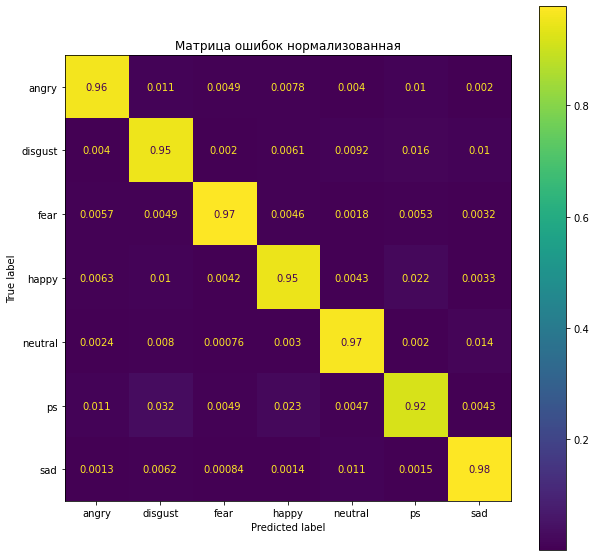

In [ ]:
# Оценка точности сети на проверочной выборке
eval_model(model_2, x_new_dataset_scaled, y_new_dataset)